# Build Enviroment

In [1]:
!pip install unidecode
!pip install contractions

     |████████████████████████████████| 245kB 10.9MB/s 
     |████████████████████████████████| 317kB 12.0MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81701 sha256=85c5a6badbd428c4852e4a8e68576c783836e2b1a4d021339cad2d02ef8b380c
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


# Function

In [2]:
from bs4 import BeautifulSoup 
import unidecode
import contractions
from gensim.parsing.preprocessing import remove_stopwords
import re
from nltk.stem.porter import PorterStemmer

def preprocessing(text): 
  text = BeautifulSoup(text, 'html.parser')
  text = text.get_text(separator=' ')
  text = unidecode.unidecode(text)
  text = contractions.fix(text)
  text = remove_stopwords(text)
  text = re.sub(r'http\S+', '', text)
  text = re.sub('[^a-zA-Z]', ' ', text)
  text = text.lower()
  text = [word for word in text.split() if len(word) > 3]
  stemmer = PorterStemmer()
  text = [stemmer.stem(word) for word in text]
  cleaned_text = ' '.join(text)
  
  return cleaned_text

In [3]:
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val

# Static

In [4]:
TRAIN_PATH = '/content/drive/MyDrive/SIGNATE/DATASET/train.csv'
TEST_PATH = '/content/drive/MyDrive/SIGNATE/DATASET/test.csv'

BATCH_SIZE = 32
EPOCHS = 20
VALIDATION_SPLIT = 0.2

# Import data

In [5]:
import pandas as pd

df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

Y_train = df_train['state'].astype(int).values
df_train = df_train.drop('state', axis=1)
test_id = df_test['id']

# train_html = df_train['html_content'].apply(preprocessing)
# test_html = df_test['html_content'].apply(preprocessing)
# data_html = pd.concat([df_train['html_content'], df_test['html_content']], axis=0).apply(preprocessing)

train_html = df_train['html_content'].values
test_html = df_test['html_content'].values
data_html = pd.concat([df_train['html_content'], df_test['html_content']], axis=0)

df_train = df_train.drop('html_content', axis=1)
df_test = df_test.drop('html_content', axis=1)
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

df = pd.concat([df_train, df_test], axis=0)

print('train_html shape: {0}'.format(train_html.shape))
print('test_html shape: {0}'.format(test_html.shape))
print('data_html shape: {0}'.format(data_html.shape))

train_html shape: (10545,)
test_html shape: (10544,)
data_html shape: (21089,)


In [6]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

train_data = np.empty((len(df_train), 0), int)
test_data = np.empty((len(df_test), 0), int)

for column in df.columns:
  one_hot_encoder = OneHotEncoder(sparse=False)
  one_hot_encoder.fit(df[column].values.reshape(-1, 1))
  train_temp = one_hot_encoder.transform(df_train[column].values.reshape(-1, 1))
  test_temp = one_hot_encoder.transform(df_test[column].values.reshape(-1, 1))
  train_data = np.concatenate([train_data, train_temp], axis=1)
  test_data = np.concatenate([test_data, test_temp], axis=1)

print('train_data: {0}'.format(train_data.shape))
print('test_data: {0}'.format(test_data.shape))

train_data: (10545, 359)
test_data: (10544, 359)


In [7]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

### 特徴量として考慮する単語の数 ###
max_features = 10000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data_html)

### 出現頻度の高い単語を取得 ###
train_html = tokenizer.texts_to_sequences(train_html)
test_html = tokenizer.texts_to_sequences(test_html)

max_len = 1000

train_html = pad_sequences(train_html, maxlen=max_len)
test_html = pad_sequences(test_html, maxlen=max_len)

print('train_html: {0}'.format(train_html.shape))
print('test_html: {0}'.format(test_html.shape))

train_html: (10545, 1000)
test_html: (10544, 1000)


In [8]:
# train_data = np.concatenate([train_data, train_html], axis=1)
# test_data = np.concatenate([test_data, test_html], axis=1)

# print('train_data: {0}'.format(train_data.shape))
# print('test_data: {0}'.format(test_data.shape))

# Create model

In [12]:
from keras.models import Model
from keras import Input
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, concatenate, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import Adagrad, RMSprop, SGD, Adam, Adadelta
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy

### LSTM Model ###
# lstm_input = Input(shape=(None,), dtype='int64', name='LSTM')
# x = Embedding(max_features, BATCH_SIZE)(lstm_input)
# lstm_model = LSTM(BATCH_SIZE)(x)

### 1d CNN ###

cnn_input = Input(shape=(None,), dtype='int64', name='1dCNN')
x = Embedding(max_features, BATCH_SIZE)(cnn_input)
x = Conv1D(BATCH_SIZE, 10, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(BATCH_SIZE, 7, activation='relu')(x)
cnn_model = GlobalMaxPooling1D()(x)

nn_input = Input(shape=(359,))
y = Dense(32, activation='relu')(nn_input)
nn_model = Dense(32, activation='relu')(y)

concatenated = concatenate([cnn_model, nn_model], axis=-1)

output = Dense(1, activation='sigmoid')(concatenated)

# model = Model([lstm_input, nn_input], output)
model = Model([cnn_input, nn_input], output)

model.compile(optimizer=Adam(lr=1e-3), loss=binary_crossentropy, metrics=[binary_accuracy, f1_score])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
1dCNN (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 32)     320000      1dCNN[0][0]                      
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 32)     10272       embedding_3[0][0]                
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, None, 32)     0           conv1d_2[0][0]                   
______________________________________________________________________________________________

# Training

|Model|BATCH_SIZE|optimizer|learning rate|validation f1 score|Public Leaderboard|
|:--:|:--:|:--:|:--:|:--:|:--:|
|LSTM+NN|10|Adagrad|1e-3|0.5647 [best] [last]|Nan|
|LSTM+NN|10|RMSprop|1e-3|**0.7874 [best - 2 epochs] 0.7606 [last]**|0.7408 [best] **0.7602 [last]**|
|LSTM+NN|10|SGD|1e-3|0.6029 [best] [last]|Nan|
|LSTM+NN|10|Adam|1e-3|0.7635 [best - 1 epoch] 0.7156 [last]|Nan|
|LSTM+NN|10|Adadelta|1e-3|0.5062 [best] [last]|Nan|
|LSTM+NN|10|RMSprop|1e-4|0.7865 [best - 9 epochs] 0.7642 [last]|Nan|
|LSTM+NN|10|RMSprop|1e-5|0.6705 [best] [last]|Nan|
|LSTM+NN|20|RMSprop|1e-3|[best] [last]|[best] [last]|

In [13]:
from keras.callbacks import ModelCheckpoint

# CALLBACKS_LIST = [ModelCheckpoint(filepath='/content/drive/MyDrive/SIGNATE/DATASET/LSTM_AND_NN.h5', monitor='val_f1_score', save_best_only=True,)]

history = model.fit([train_html, train_data], Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)
# history = model.fit([train_html, train_data], Y_train, epochs=EPOCHS, callbacks=CALLBACKS_LIST, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/20
264/264 [==============================] - 12s 18ms/step - loss: 0.6276 - binary_accuracy: 0.6360 - f1_score: 0.5820 - val_loss: 0.4639 - val_binary_accuracy: 0.7643 - val_f1_score: 0.7661
Epoch 2/20
264/264 [==============================] - 4s 16ms/step - loss: 0.3941 - binary_accuracy: 0.8149 - f1_score: 0.8083 - val_loss: 0.4357 - val_binary_accuracy: 0.7824 - val_f1_score: 0.7584
Epoch 3/20
264/264 [==============================] - 4s 16ms/step - loss: 0.2980 - binary_accuracy: 0.8725 - f1_score: 0.8698 - val_loss: 0.4385 - val_binary_accuracy: 0.7956 - val_f1_score: 0.7873
Epoch 4/20
264/264 [==============================] - 4s 16ms/step - loss: 0.1900 - binary_accuracy: 0.9286 - f1_score: 0.9265 - val_loss: 0.5368 - val_binary_accuracy: 0.7838 - val_f1_score: 0.7645
Epoch 5/20
264/264 [==============================] - 4s 16ms/step - loss: 0.0982 - binary_accuracy: 0.9669 - f1_score: 0.9666 - val_loss: 0.6392 - val_binary_accuracy: 0.7686 - val_f1_score: 0.7726
Epoc

# Plot model

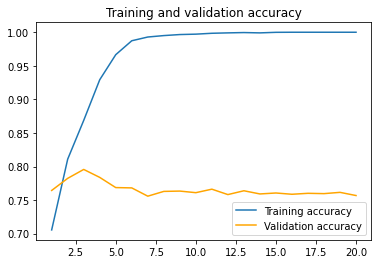

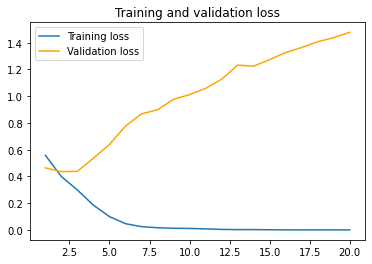

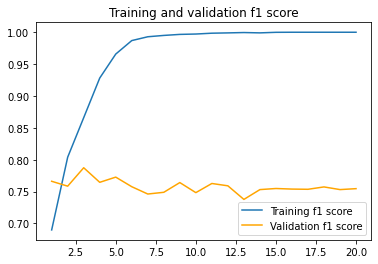

In [14]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(1, EPOCHS+1)

plt.plot(epochs, acc, linestyle='solid', label='Training accuracy')
plt.plot(epochs, val_acc, linestyle='solid', color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, linestyle='solid', color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()
plt.plot(epochs, f1, linestyle='solid', label='Training f1 score')
plt.plot(epochs, val_f1, linestyle='solid', color='orange', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend()

plt.show()

# Submit

In [ ]:
# from keras.models import load_model
import numpy as np

# model = load_model('/content/drive/MyDrive/SIGNATE/DATASET/LSTM_AND_NN.h5', custom_objects={'f1_score': f1_score})

predicted = model.predict([test_html, test_data])

df_sub = pd.concat([test_id, pd.DataFrame(np.round(predicted), columns=['predicted']).astype(int)], axis=1)

print('df_sub shape: {0}'.format(df_sub.shape))

# df_sub.to_csv('/content/drive/MyDrive/SIGNATE/DATASET/submission.csv', index=False, header=False)
df_sub.to_csv('submission.csv', index=False, header=False)

df_sub.head()

# Evaluate Model

|Model|avg f1 score|Public Leaderboard|DATASET|
|:--:|:--:|:--:|:--:|
|SVM|0.5855|0.5901|cleaned|
|LightGBM|0.7565|0.7533|cleaned|

In [ ]:
# from sklearn.model_selection import cross_val_score
# from sklearn import svm
# import lightgbm as lgb
# import time

# # model = svm.SVC()
# model = lgb.LGBMClassifier()

# start = time.time()

# scores = cross_val_score(model, train_data, Y_train, scoring='f1', cv=10)

# elapsed_time = time.time() - start

# print('Elapsed time: {0} hours'.format(elapsed_time / 3600))
# print('Cross-Validation scores: {0}'.format(scores))
# print('Average score: {}'.format(np.mean(scores)))

# Train and Predict Model

In [ ]:
# # clf = svm.SVC()
# clf = lgb.LGBMClassifier()

# clf.fit(train_data, Y_train)

# predicted = clf.predict(test_data)

# df_sub = pd.concat([test_id, pd.DataFrame(predicted, columns=['predicted'])], axis=1)

# print(df_sub.dtypes)
# print('df_sub shape: {0}'.format(df_sub.shape))

# df_sub.to_csv('submission.csv', index=False, header=False)

# df_sub.head()